# Определение возраста покупателей

**Описание исследования**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В нашем распоряжении набор фотографий людей с указанием возраста.

**Цель исследования**

Разработать решение для персонализации предлагаемой продукции супермаркета.

**Задача исследования**

Построить модель, которая по фотографии определит приблизительный возраст человека. 

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People.

В нашем распоряжении одна папка со всеми изображениями и CSV-файл с двумя колонками: file_name и real_age.

In [1]:
#загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize":(15,10)})

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
image_set = ImageDataGenerator(rescale=1./255)
image_set_flow = image_set.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Количество фотографий совпадает с их количеством в таблице. У нас есть 7591 фотографий людей, для которых мы знаем их реальный возраст.

Построим график распределения возраста в выборке

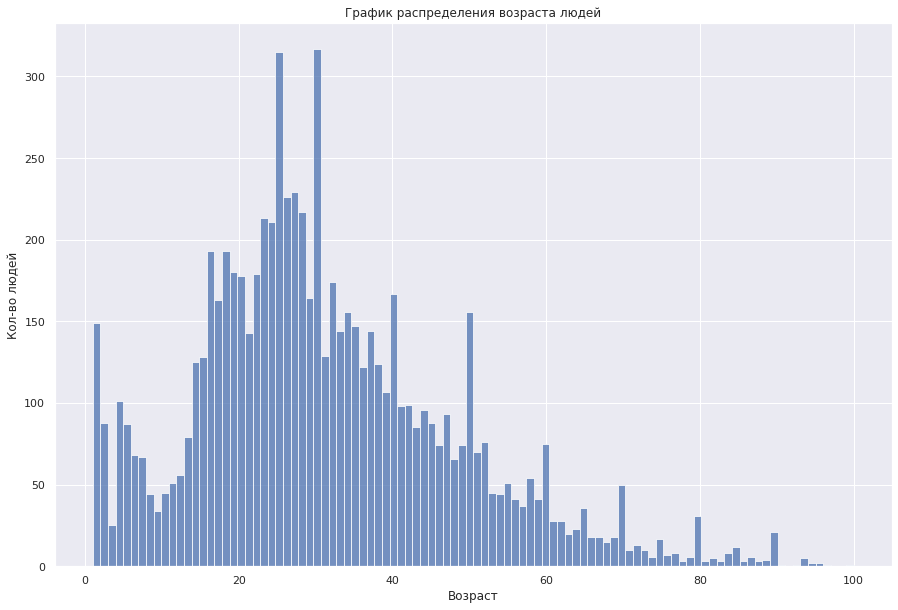

In [4]:
sns.histplot(data=labels, bins=100, x='real_age').set_title('График распределения возраста людей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во людей');

Больше всего людей в возрасте от 20 до 30 лет.

Отобразим 15 фотографий и посмотрим как они выглядят.

In [5]:
features, target = next(image_set_flow)

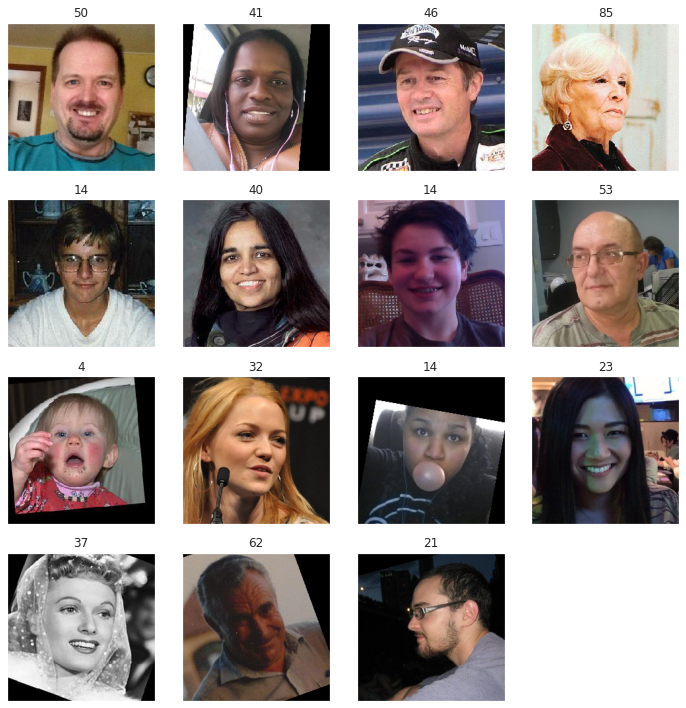

In [6]:
# выводим 15 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На многих изображениях не видно глаз, так же некоторые фотографии имеют меньший размер, чем остальные.

Исходя из нашего исследования можно сказать, что модель будет ошибаться при прогнозе людей старше 60 лет, из-за малого количества их в выборке. Благодаря фотографиям людей с различных ракурсов, модель сможет прогнозировать более точное значения возраста, покупателям не придеться смотреть глазами в камеру для определения их возраста.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен как код в текстовой ячейке.

Модель выбираем ResNet50, метрикой качества для модели будем использовать MAE. Нам необходимо получить значение метрики < 8.

```python
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255,
        horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
    validation_split=0.25, 
    rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, include_top=False, 
                        weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 65s - loss: 250.2250 - mae: 11.1808 - val_loss: 527.0272 - val_mae: 17.8806
Epoch 2/10
178/178 - 50s - loss: 77.8184 - mae: 6.7064 - val_loss: 366.1550 - val_mae: 14.1320
Epoch 3/10
178/178 - 49s - loss: 50.6800 - mae: 5.4448 - val_loss: 250.7494 - val_mae: 11.7754
Epoch 4/10
178/178 - 50s - loss: 36.2877 - mae: 4.5535 - val_loss: 143.9945 - val_mae: 9.0764
Epoch 5/10
178/178 - 49s - loss: 27.3740 - mae: 3.9679 - val_loss: 82.0475 - val_mae: 6.9156
Epoch 6/10
178/178 - 50s - loss: 21.3549 - mae: 3.5238 - val_loss: 76.8136 - val_mae: 6.4908
Epoch 7/10
178/178 - 49s - loss: 17.5442 - mae: 3.1940 - val_loss: 77.0807 - val_mae: 6.4985
Epoch 8/10
178/178 - 51s - loss: 14.8976 - mae: 2.9551 - val_loss: 66.4890 - val_mae: 6.1925
Epoch 9/10
178/178 - 51s - loss: 12.4817 - mae: 2.7038 - val_loss: 62.9990 - val_mae: 6.0114
Epoch 10/10
178/178 - 53s - loss: 10.0961 - mae: 2.4098 - val_loss: 73.6952 - val_mae: 6.4116

60/60 - 11s - loss: 73.6952 - mae: 6.4116
Test MAE: 6.4116
```

## Анализ обученной модели

В моделе ResNet50 была убрана верхушка для настройки полносвязного слоя, мы использовали для него один нейрон с функцией активации ReLu.
Также для модели были загруженны уже предобученные на большом датасете веса, что помогло в получении лучшего результата.
Мы использовали оптимизатор Adam с параметром скорости обучения lr=0.0001. Для обучения мы использовали 10 эпох. Итоговой метрикой на тестовой выборке получили значение 6.41.

По полученным метрикам видно небольшое переобучение модели, с каждой следующей эпохой модель лучше прогнозирует на тестовых данных, но при этом переобучается на тренировочных данных.

Полученное значение метрики на тестовой выборке меньше 8, а значит мы обучили модель правильно и можем переходить к общим выводам.

## Выводы

Мы разработали решение для обработки фотографий покупателей. Для этого мы построили модель, которая по фотографии может определить приблизительный возраст человека.

В нашем распоряжении было 7591 фотографий людей, для которых известен их реальный возраст.

В ходе анализа мы установили, что больше всего людей в возрасте от 20 до 30 лет. На многих изображениях не видно глаз, так же некоторые фотографии имеют меньший размер, чем остальные. Модель скорее всего будет ошибаться при прогнозе людей старше 60лет, из-за малого количества их в выборке. Однако благодаря фотографиям людей с различных ракурсов, модель сможет прогнозировать более точное значения возраста, покупателям не придеться смотреть глазами в камеру для определения их возраста.

Для обучения мы использовали модель ResNet50, для проверки ее качества выбрали метрику MAE. Сам процесс обучения был выполнен в отдельном GPU-тренажере.

Модель получила отличную метрику 6.41, которая меньше <8. Данная модель точно устроит супермаркет и они смогут использовать нашу модель для персонализации своих товаров.

Для моих коллег могу дать рекомендацию рассмотреть другие функции потерь и также рассмотреть другие подборы параметров для еще большего улучшения качества модели.